# ***Assignement 2***
Gualtieri Stefano, matr. 825244


In [83]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import regularizers

from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report

## ***Inspecting the data***

Let's load the dataset and inspect it:

In [84]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [85]:
x_train = np.load("drive/MyDrive/AML/Assignement2/x_train.npy")
y_train = np.load("drive/MyDrive/AML/Assignement2/y_train.npy")
x_test = np.load("drive/MyDrive/AML/Assignement2/x_test.npy")
y_test = np.load("drive/MyDrive/AML/Assignement2/y_test.npy")

Print the shapes of the data: we are working with a training set of 72.247 images (28x39), and a test set of 24.083 examples in the same format.

In [86]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (72247, 28, 39)
y_train shape: (72247,)
x_test shape: (24083, 28, 39)
y_test shape: (24083,)


We can also check the number of categories of our calssicazion problem: there are 50 classes, from 1 to 50, so we have to keep in mind that if we wan to one-hot encode the output, we must rescale the y arrays in the range: [0,49]

In [87]:
print('Some information on the output of the training set:')
print('Number of categories:',len(set(y_train)))
print('Value of categories:', set(y_train))

Some information on the output of the training set:
Number of categories: 50
Value of categories: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50}


Let's see an example of the training set:

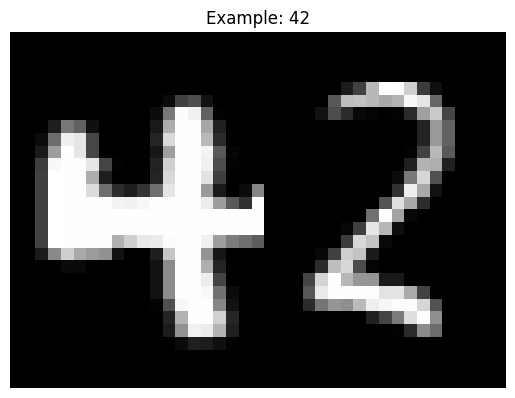

In [88]:
plt.imshow(x_train[10], cmap='gray')
plt.title(f'Example: {y_train[10]}')
plt.axis('off')
plt.show()

Let's also look at the class distribution: there is no class that doesn't have any examples belonging to it, but there are some classes that have fewer examples than others: this could represent a problem in the training phase to correctly classify these classes, so we must keep that in mind

Class 1: 2282 samples
Class 2: 292 samples
Class 3: 2049 samples
Class 4: 1941 samples
Class 5: 1819 samples
Class 6: 641 samples
Class 7: 2102 samples
Class 8: 560 samples
Class 9: 2046 samples
Class 10: 2311 samples
Class 11: 2548 samples
Class 12: 766 samples
Class 13: 358 samples
Class 14: 634 samples
Class 15: 2055 samples
Class 16: 2214 samples
Class 17: 318 samples
Class 18: 471 samples
Class 19: 2403 samples
Class 20: 1982 samples
Class 21: 646 samples
Class 22: 2029 samples
Class 23: 2073 samples
Class 24: 413 samples
Class 25: 555 samples
Class 26: 2034 samples
Class 27: 2132 samples
Class 28: 1926 samples
Class 29: 1979 samples
Class 30: 276 samples
Class 31: 787 samples
Class 32: 832 samples
Class 33: 2159 samples
Class 34: 2050 samples
Class 35: 1885 samples
Class 36: 2111 samples
Class 37: 477 samples
Class 38: 792 samples
Class 39: 406 samples
Class 40: 2060 samples
Class 41: 444 samples
Class 42: 1894 samples
Class 43: 279 samples
Class 44: 1940 samples
Class 45: 1807 s

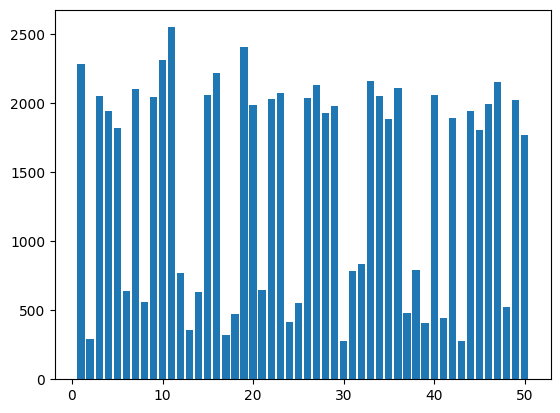

In [89]:
val, count = np.unique(y_train, return_counts=True)
for x, y in zip(val, count):
  print(f'Class {x}: {y} samples')

plt.bar(val, count)
plt.show()

## ***Preparing the data***

Let's apply some preprocessing on the training and test data:

- We are going to concatanate the input in an 1d array with dimension 1092(=28*39), and then normalize this array by dividing each entry by 255
- We are going to decrease the value of y_train and y_test so we can have the range to be [0,49] (that it's is necessary to one-hote encode the y_train and y_test arrays)


In [90]:
x_train = x_train.reshape(72247, 1092)
x_test = x_test.reshape(24083, 1092)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")


x_train /= 255
x_test /= 255

y_train = [y - 1 for y in y_train]
y_test = [y - 1 for y in y_test]

y_train_one_hot =  to_categorical(y_train, 50)
y_test_one_hot = to_categorical(y_test, 50)

Let's use the train data to obtain a validation set that we can use during the training phase to evaluate the model:

In [91]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train_one_hot, test_size=0.2, random_state=43)

In [92]:
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"Y_val.shape: {Y_val.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test_one_hot.shape}")

X_train.shape: (57797, 1092)
Y_train.shape: (57797, 50)
X_val.shape: (14450, 1092)
Y_val.shape: (14450, 50)
x_test.shape: (24083, 1092)
y_test.shape: (24083, 50)


# ***Fisrt Task***
The assignment consists in three tasks, in this section we are going to look at the first one. We want to build a classifier using a FFNN, to classify the dataset we imported.
We are going now to implement two models, one without and one with the use of any regularization technique. Later, we are going to compare them on the test set

## ***Without Regularization***


***Building the network***

We are going to use a FFNN with:

- an input shape of the dimension of the input data (28*39=1092), 4 hidden layers with RELU as the activation function. The size of the hidden layers decrease progressivly, se we encourage the network to gradually learn compressed rappresentation of the input data. The first layer is pretty large, so the NN can capture a broad range of features, and as we go deeper in the model, the shape of the layers become more small, and this behaviour help the NN to prevent overfitting. Every hidden layer has RELU as the activation function, that helps the NN to learn complexpatterns in the data and is computationally efficient

- an output layer with 50 neurons, as the shape of y_train and y_test after one hot encoding. Each output neuron represent a probability of the given example belonging to a specific class

- categorical_crossentropy as the loss function, that it's perfect for a multi-class classification problem

- adam as the optimizer: after several test, I saw that the adam optimizer was performing bettere than the SGD, because it was helping the NN converging faster than the second one; that could be because adam use a dinamic learning rate, adjusting it for each parameter, and for a complex problem like image classficiation it could be better than using always the same parameter

- a batch size equal to 128, that is a common number in machine learning; while bigger values could lead to faster models, this value helps to find a nice tradeoff between computational efficiency and frequency of wieght update

In [93]:
dim = X_train.shape[1]
print('Input Shape =', dim)

nb_classes = Y_train.shape[1]
print('Output Shape =', nb_classes)

model = Sequential()
model.add(Input((dim,)))
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(nb_classes, activation = "softmax"))


model.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy',metrics=['accuracy'])

Input Shape = 1092
Output Shape = 50


In [94]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                     │ (None, 256)                 │         279,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,210 (1.24 MB)

 Trainable params: 324,210 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
network_history = model.fit(X_train, Y_train, batch_size=128,
                            epochs=50, verbose=2, validation_data=(X_val, Y_val))

Epoch 1/50
452/452 - 6s - 13ms/step - accuracy: 0.5426 - loss: 1.8026 - val_accuracy: 0.7295 - val_loss: 0.9866
Epoch 2/50
452/452 - 5s - 10ms/step - accuracy: 0.7743 - loss: 0.8064 - val_accuracy: 0.7892 - val_loss: 0.7463
Epoch 3/50
452/452 - 4s - 10ms/step - accuracy: 0.8195 - loss: 0.6395 - val_accuracy: 0.8206 - val_loss: 0.6505
Epoch 4/50
452/452 - 3s - 7ms/step - accuracy: 0.8475 - loss: 0.5383 - val_accuracy: 0.8413 - val_loss: 0.5661
Epoch 5/50
452/452 - 6s - 14ms/step - accuracy: 0.8673 - loss: 0.4616 - val_accuracy: 0.8588 - val_loss: 0.4937
Epoch 6/50
452/452 - 4s - 8ms/step - accuracy: 0.8845 - loss: 0.4012 - val_accuracy: 0.8655 - val_loss: 0.4540
Epoch 7/50
452/452 - 6s - 13ms/step - accuracy: 0.8980 - loss: 0.3532 - val_accuracy: 0.8793 - val_loss: 0.4100
Epoch 8/50
452/452 - 4s - 10ms/step - accuracy: 0.9080 - loss: 0.3143 - val_accuracy: 0.8864 - val_loss: 0.3808
Epoch 9/50
452/452 - 4s - 9ms/step - accuracy: 0.9191 - loss: 0.2803 - val_accuracy: 0.8950 - val_loss: 0.

Let's now plot the accuracy and the lost through the epochs:

In [96]:
def plot_loss(history):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title("Loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title("Accuracy")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

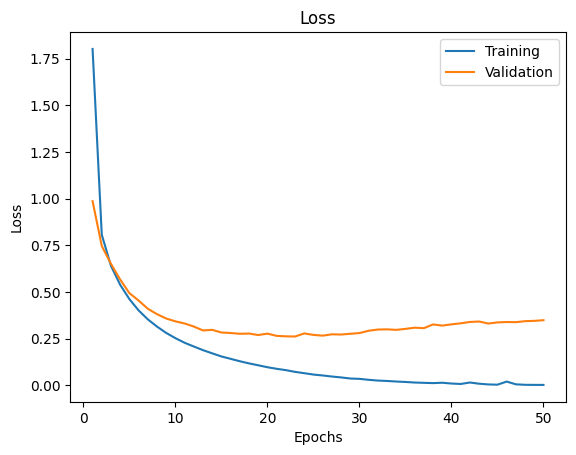

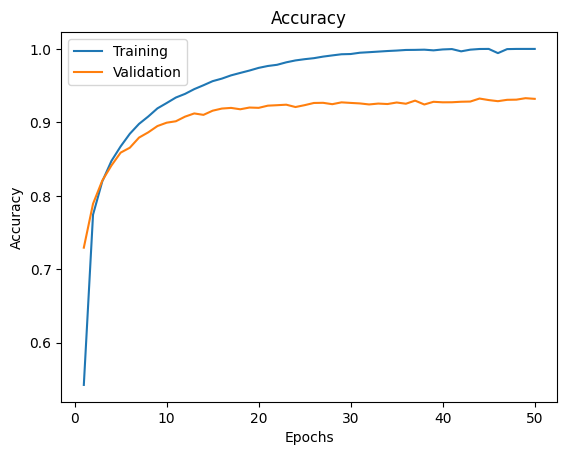

In [97]:
plot_loss(network_history)
plot_accuracy(network_history)

Let's make some comment on the results we obtain in this section:

- ***Training result***: we can see that the NN is learning pretty well, reaching a nice accuracy on the training set in few epochs. We can predict from the training curve that with more epochs the model would perform better on the training set

- ***Validation result***: we can also clearly see that the model, also with 50 epochs, it's going in overfitting, because at a certain point the validation accuracy remain stable while the training accuracy continue to grows, and we can predict that it will not performe so well on generalization when it will be applied to a test set that it never saw.

## ***With Regularization***
Let's now try to implement a model with L2 norm tecnique: since in our problem there was an overfitting problem, we can try to apply L2 to each dense layer in the NN; this regularization tecnique penalizes large weights: it works by adding an extra term to the loss function (this term is proportional to the sum of the squares of all the weights of the model). We can later choose this factor of proportionality, and after some tests the best value was 0.001.
All the other hyperparameters of the model were left as the previous one, since it wat performing well on the training set.

In [98]:
l2_regularization = l2(0.001)


model_d = Sequential()
model_d.add(Input((dim,)))
model_d.add(Dense(256, activation = "relu", kernel_regularizer=l2_regularization))
model_d.add(Dense(128, activation = "relu", kernel_regularizer=l2_regularization))
model_d.add(Dense(64, activation = "relu", kernel_regularizer=l2_regularization))
model_d.add(Dense(nb_classes, activation = "softmax", kernel_regularizer=l2_regularization))


model_d.compile(optimizer=Adam(learning_rate=0.0002), loss='categorical_crossentropy',metrics=['accuracy'])

In [99]:
model_d.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                     │ (None, 256)                 │         279,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 50)                  │           3,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 324,210 (1.24 MB)

 Trainable params: 324,210 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.15,restore_best_weights=True)
network_history_d = model_d.fit(X_train, Y_train, batch_size=128, epochs=50, verbose=2, validation_data=(X_val, Y_val))

Epoch 1/50
452/452 - 5s - 12ms/step - accuracy: 0.5379 - loss: 2.4743 - val_accuracy: 0.7197 - val_loss: 1.5398
Epoch 2/50
452/452 - 6s - 14ms/step - accuracy: 0.7664 - loss: 1.3445 - val_accuracy: 0.7887 - val_loss: 1.2545
Epoch 3/50
452/452 - 4s - 8ms/step - accuracy: 0.8112 - loss: 1.1506 - val_accuracy: 0.8165 - val_loss: 1.1285
Epoch 4/50
452/452 - 5s - 11ms/step - accuracy: 0.8374 - loss: 1.0403 - val_accuracy: 0.8335 - val_loss: 1.0459
Epoch 5/50
452/452 - 7s - 16ms/step - accuracy: 0.8545 - loss: 0.9599 - val_accuracy: 0.8459 - val_loss: 0.9796
Epoch 6/50
452/452 - 7s - 14ms/step - accuracy: 0.8669 - loss: 0.8986 - val_accuracy: 0.8592 - val_loss: 0.9231
Epoch 7/50
452/452 - 6s - 14ms/step - accuracy: 0.8787 - loss: 0.8458 - val_accuracy: 0.8680 - val_loss: 0.8757
Epoch 8/50
452/452 - 4s - 8ms/step - accuracy: 0.8893 - loss: 0.8005 - val_accuracy: 0.8767 - val_loss: 0.8294
Epoch 9/50
452/452 - 4s - 8ms/step - accuracy: 0.8967 - loss: 0.7631 - val_accuracy: 0.8858 - val_loss: 0.

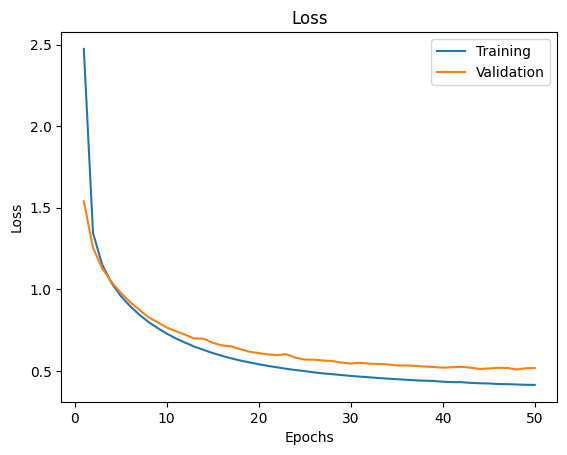

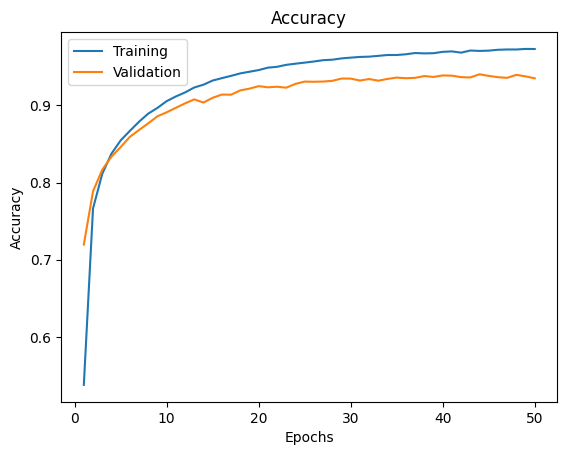

In [101]:
plot_loss(network_history_d)
plot_accuracy(network_history_d)

## ***Compare the two models***:
Let's compare the two models of this section on the test set:

In [120]:
test_loss_without_reg, test_acc_without_reg = model.evaluate(x_test, y_test_one_hot)
test_loss_with_reg, test_acc_with_reg = model_d.evaluate(x_test, y_test_one_hot)

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9343 - loss: 0.3311
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9370 - loss: 0.5083


From the results of the training and validation phases, my personal guess is that the best model will be the regularized one, because it's showing a smaller gap between the training and validation curves (both in the accuracy and loss graphs)

The best model is in fact the regularized one: it's not only for what I've sad, bat it also reach a better value of accuracy during the inference on the test set. This is a confirm that this model works better in generalization tasks.

The major sources of error could be similarities between classes and imbalanced class distribution. In our case, some numbers could be very similar to other, maybe for the person's writing, and that is a factor that could trick the NN. For the second problem, we already saw that there are classes with less examples, so this could have been a source of noise in the training phase.

Let's now print a more detail report for the best model:

In [103]:
y_pred_reg = np.argmax(model_d.predict(x_test), axis=1)

print(classification_report(y_test, y_pred_reg))

753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       801
           1       0.90      0.71      0.80        77
           2       0.96      0.93      0.94       638
           3       0.96      0.96      0.96       676
           4       0.94      0.96      0.95       606
           5       0.96      0.95      0.95       188
           6       0.94      0.93      0.93       697
           7       0.86      0.91      0.88       185
           8       0.93      0.92      0.92       667
           9       0.96      0.98      0.97       771
          10       0.98      0.98      0.98       876
          11       0.96      0.91      0.93       261
          12       0.95      0.84      0.89        82
          13       0.88      0.91      0.89       202
          14       0.95      0.97      0.96       687
          15       0.98      0.98      0.98       751
          16       0.95      0.85      0

We can note what was said above, that is, for some of the classes in which there are few examples, the model has greater difficulty in classifying

# ***Second Task***

Let's now implement a fully connected AutoEconder.
Let's import again the data

---



In [104]:
x_train_enc = np.load("drive/MyDrive/AML/Assignement2/x_train.npy")
y_train_enc = np.load("drive/MyDrive/AML/Assignement2/y_train.npy")
x_test_enc = np.load("drive/MyDrive/AML/Assignement2/x_test.npy")
y_test_enc = np.load("drive/MyDrive/AML/Assignement2/y_test.npy")

Some preprocessing on the data:

In [105]:
x_train_enc = x_train_enc.astype('float32') / 255.
x_test_enc = x_test_enc.astype('float32') / 255.
x_train_enc = x_train_enc.reshape((len(x_train_enc), np.prod(x_train_enc.shape[1:])))
x_test_enc = x_test_enc.reshape((len(x_test_enc), np.prod(x_test_enc.shape[1:])))

### Building the network

Structure of the autoencoder:

- Inpu dimension euqal to the dimension of the input data (1092)
- The autoencoder is divided in two different parts:
  - Encoder: 4 layer of neurons, with progressively smaller dimensions (512-256-128-42); the final dimension is fixed to 42, so we can have the ratio between the input size and the encoded layer size in the range [20,30] as request
  - Decoder: it's the mirror image of the encoder part, with the final layer that uses a sigmoid function, to get a value of probability between 0 and 1
- Binary_CrossEntropy as the loss_function, since the input images are normalized to values in range 0 and 1 for each pixel
- Adam Optimizer (same considerations than the first part of the assignement)

In [106]:
encoding_dim = 42

dim = x_train_enc.shape[1]
input = Input(shape=(dim,))

downsampling_hidden_1 = Dense(512, activation = 'relu', name = "downsampling_hidden_1")(input)
downsampling_hidden_2 = Dense(256, activation = 'relu', name = "downsampling_hidden_2")(downsampling_hidden_1)
downsampling_hidden_3 = Dense(128, activation = 'relu', name = "downsampling_hidden_3")(downsampling_hidden_2)


encoded = Dense(encoding_dim, activation='relu', name = "latent")(downsampling_hidden_3)


upsampling_hidden_1 = Dense(128, activation = 'relu', name = "upsampling_hidden_1")(encoded)
upsampling_hidden_2 = Dense(256, activation = 'relu', name = "upsampling_hidden_2")(upsampling_hidden_1)
upsampling_hidden_3 = Dense(512, activation = 'relu', name = "upsampling_hidden_3")(upsampling_hidden_2)

decoded = Dense(dim, activation='sigmoid', name = "decoder")(upsampling_hidden_3)

autoencoder = Model(input, decoded)
autoencoder.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 1092)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_1 (Dense)        │ (None, 512)                 │         559,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_2 (Dense)        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ downsampling_hidden_3 (Dense)        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent (Dense)                       │ (None, 42)                  │           5,418 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_1 (Dense)          │ (None, 128)                 │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_2 (Dense)          │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ upsampling_hidden_3 (Dense)          │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Dense)                      │ (None, 1092)                │         560,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,459,566 (5.57 MB)

 Trainable params: 1,459,566 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

Training of the model:

Like in the first part, we are using adam as the optimization function and categorical crossentropy as the loss function

In [107]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["mse"])

In [108]:
network_history_encoder = autoencoder.fit(x_train_enc,x_train_enc, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.3856 - mse: 0.0957 - val_loss: 0.2521 - val_mse: 0.0493
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 0.2401 - mse: 0.0450 - val_loss: 0.2168 - val_mse: 0.0372
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 0.2121 - mse: 0.0354 - val_loss: 0.2003 - val_mse: 0.0314
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.1977 - mse: 0.0303 - val_loss: 0.1912 - val_mse: 0.0282
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.1893 - mse: 0.0275 - val_loss: 0.1859 - val_mse: 0.0265
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.1838 - mse: 0.0256 - val_loss: 0.1806 - val_mse: 0.0246
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 0.1795 - mse: 0.0242 - val_loss: 0.1791 - val_mse: 0.0241
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - loss: 0.1764 - mse: 0.0232 - val_loss: 0.1748 - val_mse: 0.0227
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 

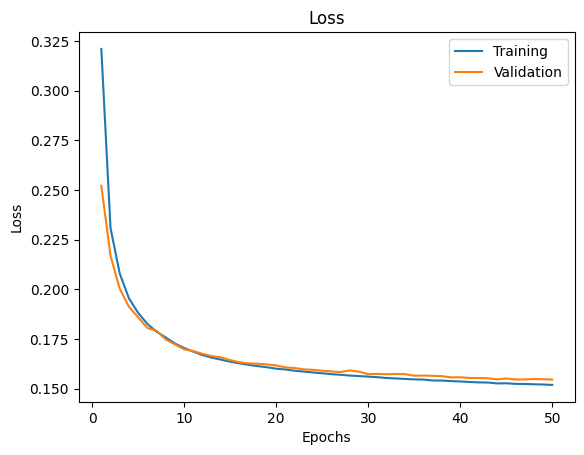

In [109]:
plot_loss(network_history_encoder)

We can see that the model is learning effectively, without occuring in generalization problems, since the validation curve is following pretty well the training curve, so there is no problem of overfitting

### 2.2 Visually Inspecting the results
Let's now compare the visual rapresentation of some input data with the recunstruction made by the autoencoder to test it's capabilities

In [110]:
encoder_model = Model(input, encoded)
decoder_model = Model(encoded, decoded)

753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


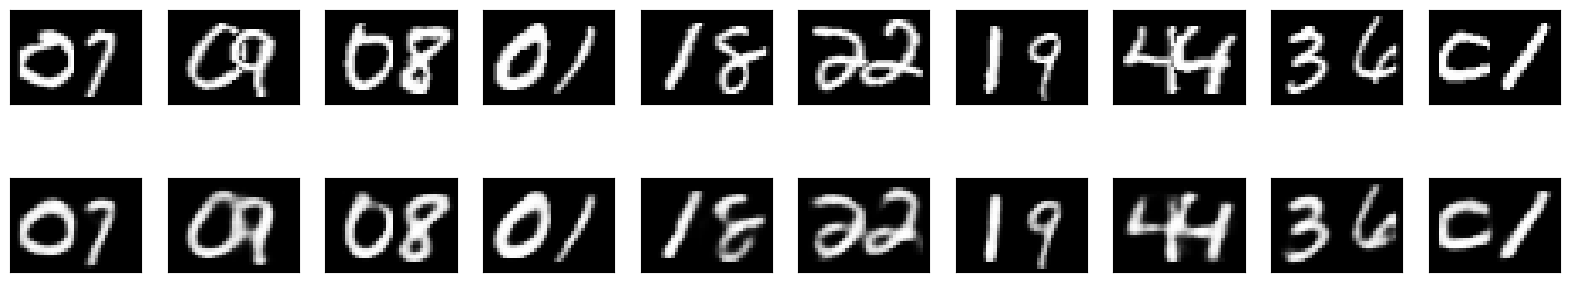

In [111]:
encoded_imgs = encoder_model.predict(x_test_enc)
decoded_imgs = decoder_model.predict(encoded_imgs)


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # orinal photo
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 39), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed photo
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see that most of the images are still recognisable; in general there is greater blurriness in all photos and a loss of detail,s, in particular along the edges. In particular in the photo of '44', the first '4' could be a '9'. We can try to use the model of the first part to see how it classificates the original version and the reconstructed version of each image:

753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


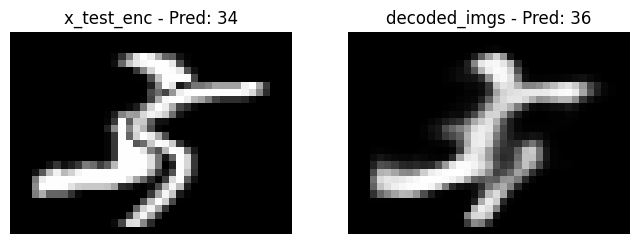

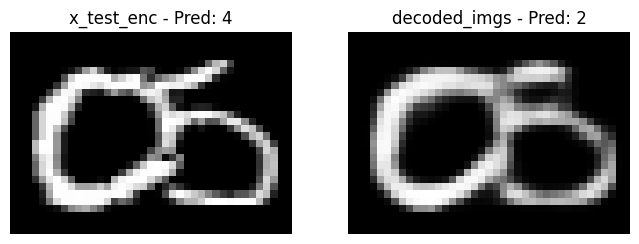

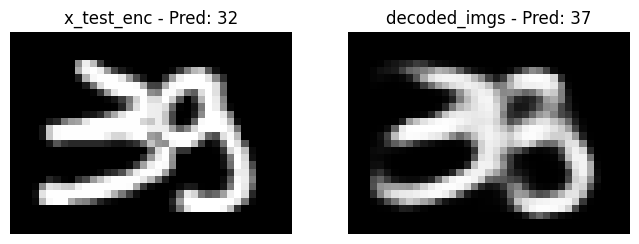

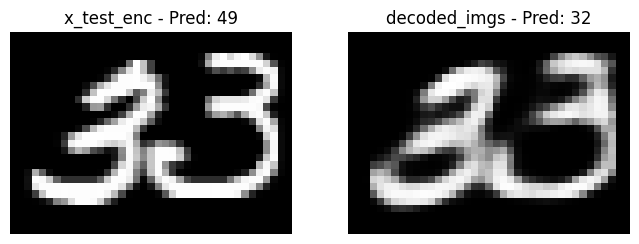

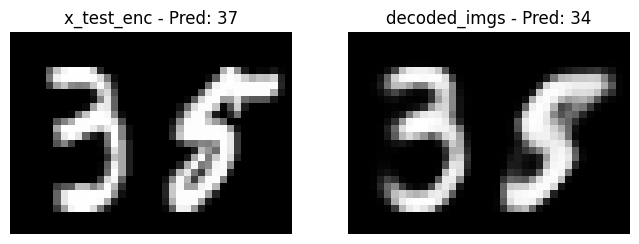

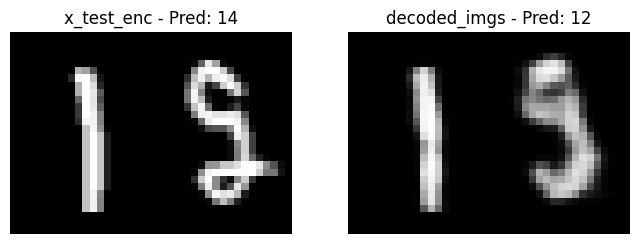

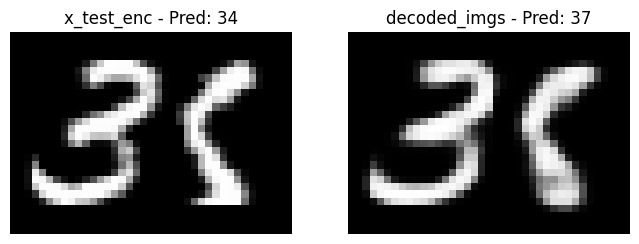

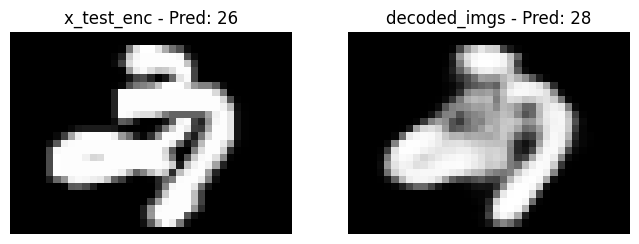

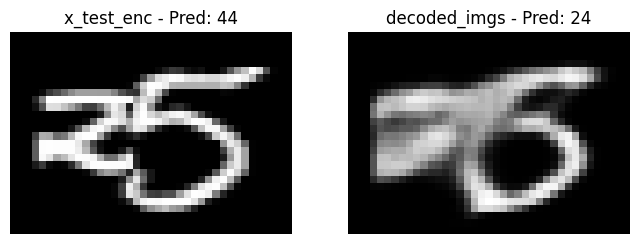

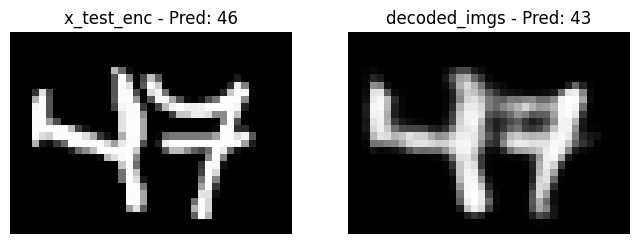

In [113]:
import random

y_pred_original = np.argmax(model_d.predict(x_test_enc), axis=1)

y_pred_decoded = np.argmax(model_d.predict(decoded_imgs), axis=1)

different_indices = [i for i in range(len(x_test_enc)) if y_pred_original[i] != y_pred_decoded[i]]


random_indices = random.sample(different_indices, min(10, len(different_indices)))


for i in random_indices:

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(x_test_enc[i].reshape(28, 39), cmap='gray')
    axes[0].set_title(f"x_test_enc - Pred: {y_pred_original[i]}")
    axes[0].axis('off')

    axes[1].imshow(decoded_imgs[i].reshape(28, 39), cmap='gray')
    axes[1].set_title(f"decoded_imgs - Pred: {y_pred_decoded[i]}")
    axes[1].axis('off')
    plt.show()


From some of these examples we can see some things:
- most of the cases where the decodec_image lead to a different classification are images that are already badly written
- in some cases, the increased blurring of the edges confuses the model
- in some cases, the model was already predicting a wrong value for the input

### Generate new samples
Let's now generate 15 new samples, and take a look a the quality

In [114]:
X_train_encoded = encoder_model.predict(x_train_enc)

encoding_mean = np.mean(X_train_encoded, axis=0)
encoding_std = np.std(X_train_encoded, axis=0)

2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


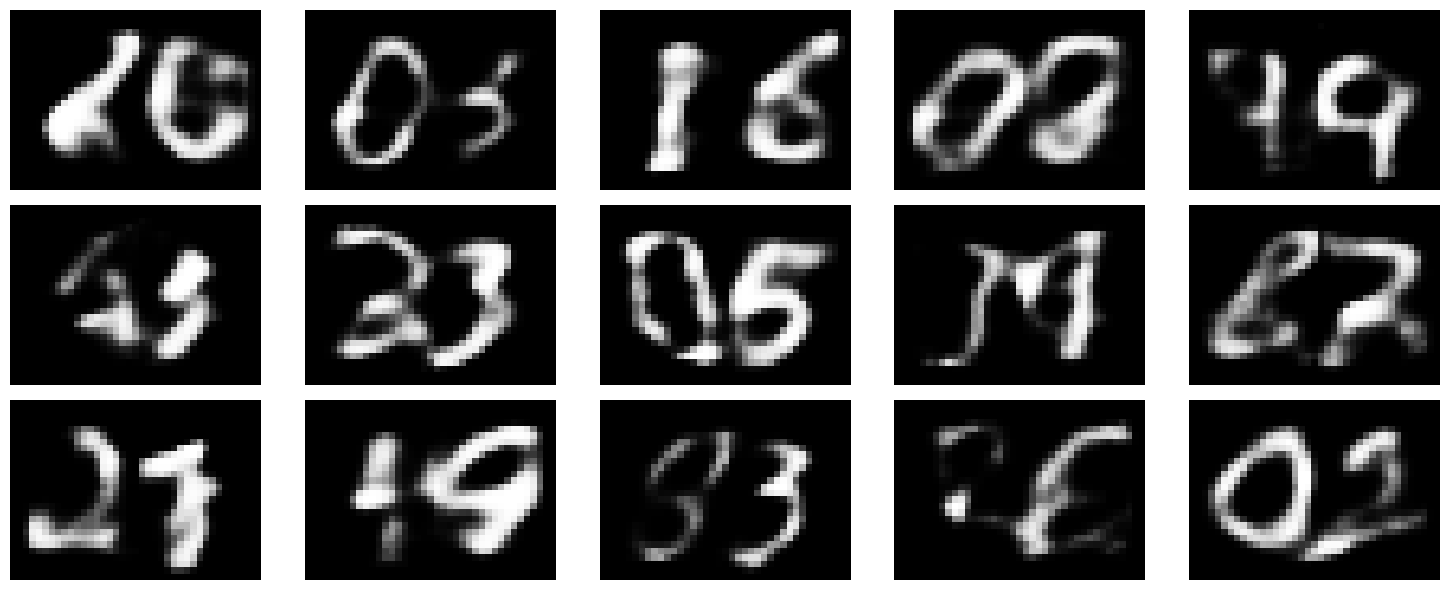

In [115]:
n = 15

random_encodings = np.random.normal(loc=encoding_mean, scale=encoding_std, size=(n, encoding_dim))

generated_images = decoder_model.predict(random_encodings)

generated_images_reshaped = generated_images.reshape(-1, 28, 39)

plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(generated_images_reshaped[i], cmap='grey')
    plt.axis('off')
plt.tight_layout()
plt.show()

From these images, we can see that the generated numbers are reasonably different and of good quality. As for the previous part, we can see that some examples are diccicult to understand due to the blurring

# ***Third Task***

Let's obtain X_train_encoded and X_test_encoded

In [116]:
X_train_encoded = encoder_model.predict(x_train_enc)
X_test_encoded = encoder_model.predict(x_test_enc)

2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


Let's now use a Random Forest model to classify the encoded data:

In [117]:
rf_encoded = RandomForestClassifier(n_estimators=100, random_state=43)
rf_encoded.fit(X_train_encoded, y_train)
y_pred_rf_encoded = rf_encoded.predict(X_test_encoded)
accuracy_rf_encoded = accuracy_score(y_test, y_pred_rf_encoded)
print(f"Test Accuracy with Encoded Representations: {accuracy_rf_encoded:.4f}")

Test Accuracy with Encoded Representations: 0.7919


Let's instead have a model that work with the original data

In [118]:
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(x_train_enc, y_train_enc)
y_pred_original = rf_original.predict(x_test_enc)
accuracy_rf_original = accuracy_score(y_test_enc, y_pred_original)
print(f"Test Accuracy with Original Data: {accuracy_rf_original:.4f}")

Test Accuracy with Original Data: 0.8528


Let's finally compare the model programmed in this assignement:

In [119]:
print("Comparison of the various model's performances:")
print(f"1. NN with regularization: {test_acc_with_reg:.4f}")
print(f"2. Random Forest on Encoded Data: {accuracy_rf_encoded:.4f}")
print(f"3. Random Forest on Original Data: {accuracy_rf_original:.4f}")

Comparison of the various model's performances:
1. NN with regularization: 0.9398
2. Random Forest on Encoded Data: 0.7919
3. Random Forest on Original Data: 0.8528


We can see that the best model is the one from section one with L2 regularization. From the other two results, we can see that the model that works with the original data obtain a better value of accuracy, but also with encoded data the model can learn from them and work pretty well